In [1]:
import numpy as np
from enum import IntEnum
from copy import deepcopy
import matplotlib.pyplot as plt
#plt.style.use('seaborn-notebook')
#plt.style.use('seaborn-whitegrid')
import matplotlib.colors as mcolors
from collections import defaultdict

In [2]:
class Action(IntEnum):
    up = 0
    right = 1
    down = 2
    left = 3

action_to_str = {
    Action.up : "up",
    Action.right : "right",
    Action.down : "down",
    Action.left : "left",
}

action_to_offset = {
    Action.up : (-1, 0),
    Action.right : (0, 1),
    Action.down : (1, 0),
    Action.left : (0, -1),
}

In [7]:
from typing_extensions import final
class GridWorld:

    def __init__(self, height, width, goal, goal_value=1.0, danger=[], danger_value=-1.0, blocked=[], noise=0.0):
        """
        Initialize the GridWorld environment.
        Creates a gridworld like MDP
         - height (int): Number of rows
         - width (int): Number of columns
         - goal (int): Index number of goal cell
         - goal_value (float): Reward given for goal cell
         - danger (list of int): Indices of cells marked as danger
         - danger_value (float): Reward given for danger cell
         - blocked (list of int): Indices of cells marked as blocked (can't enter)
         - noise (float): probability of resulting state not being what was expected
        """

        self._width = width
        self._height = height
        self._grid_values = [0 for _ in range(height * width)] # Initialize state values.
        self._goal_value = goal_value
        self._danger_value = danger_value
        self._goal_cell = goal
        self._danger_cells = danger
        self._blocked_cells = blocked
        self._noise = noise # Noise level in the environment.
        assert noise >= 0.0 and noise < 1.0 # Ensure valid noise value.
        self.create_next_values() # Initialize the next state values.


    def reset(self):
        """
        Reset the state values to their initial state.
        """
        self._grid_values = [0 for _ in range(self._height * self._width)]
        self.create_next_values()


    def _inbounds(self, state):
        """
        Check if a state index is within the grid boundaries.
        """
        return state >= 0 and state < self._width * self._height

    def _inbounds_rc(self, state_r, state_c):
        """
        Check if row and column indices are within the grid boundaries.
        """
        return state_r >= 0 and state_r < self._height and state_c >= 0 and state_c < self._width

    def _state_to_rc(self, state):
        """
        Convert a state index to row and column indices.
        """
        return state // self._width, state % self._width

    def _state_from_action(self, state, action):
        """
        Gets the state as a result of applying the given action
        """
        #TO DO:
        row, col = self._state_to_rc(state)

        if action == "up":
            temp_row, temp_col = row - 1, col
        elif action == "down":
            temp_row, temp_col = row + 1, col
        elif action == "left":
            temp_row, temp_col = row, col - 1
        elif action == "right":
            temp_row, temp_col = row, col + 1

        temp_state = temp_row * self._width + temp_col

        #if temp state is valid and not blocked, thats the new state;return it
        if self._inbounds_rc(temp_row, temp_col):
            new_state = temp_state
            if new_state not in self._blocked_cells:
                return new_state
        return state #stay put if temp state invalid


    def is_terminal(self, state):
        """
        Returns true if a state is terminal (goal, or danger)
        """
        #To Do:
        if (state == self._goal_cell) or (state in self._danger_cells):
            return True

    def get_states(self):
        """
        Gets all non-terminal states in the environment
        """
        #TO DO:
        states = []
        for s in range(self._height * self._width):
            if not self.is_terminal(s) and s not in self._blocked_cells: #commenting out this part after the and statement doesn't change anything from what I can tell
                states.append(s)
        return states

    def get_actions(self, state):
        """
        Returns a list of valid actions given the current state
        """
        #TO DO:
        actions = []
        row, col = self._state_to_rc(state)
        #check surrouding tiles
        #if legal, in bounds, add to list of valid actions, return list
        if self._inbounds_rc(row - 1, col) and state - self._width not in self._blocked_cells:
            actions.append("up")
        if self._inbounds_rc(row + 1, col) and state + self._width not in self._blocked_cells:
            actions.append("down")
        if self._inbounds_rc(row, col - 1) and state - 1 not in self._blocked_cells:
            actions.append("left")
        if self._inbounds_rc(row, col + 1) and state + 1 not in self._blocked_cells:
            actions.append("right")
        return actions


    def get_reward(self, state):
        """
        Get the reward for being in the current state
        """
        assert self._inbounds(state)
        # Reward is non-zero for danger or goal
        #TO DO:
        if state == self._goal_cell:
            return self._goal_value
        elif state in self._danger_cells:
            return self._danger_value
        else:
            return 0.0

    def get_transitions(self, state, action):
        """
        Get a list of transitions as a result of attempting the action in the current state
        Each item in the list is a dictionary, containing the probability of reaching that state and the state itself
        """
        #TO DO:
        transitions = []
        if self.is_terminal(state):
            return transitions
        temp_state = self._state_from_action(state,action)
        #assuming we do that action, as inteneded
        transitions.append({'prob':1.0-self._noise, 'state':temp_state})
        #accounting for other actions due to noise
        for act in ['up', 'down', 'left', 'right']:
            if act != action:
                temp_state = self._state_from_action(state, act)
                transitions.append({'prob':self._noise/3, 'state':temp_state})

        return transitions


    def get_value(self, state):
        """
        Get the current value of the state
        """
        assert self._inbounds(state)
        return self._grid_values[state]

    def create_next_values(self):
        """
        Creates a temporary storage for state value updating
        If this is not used, then asynchronous updating may result in unexpected results
        To use properly, run this at the start of each iteration
        """
        #TO DO:
        self._next_values = []
        for _ in range(self._height * self._width):
            self._next_values.append(0.0)

    def set_next_values(self):
        """
        Set the state values from the temporary copied values
        To use properly, run this at the end of each iteration
        """
        # TO DO:
        self._grid_values = self._next_values.copy()

    def set_value(self, state, value):
        """
        Set the value of the state into the temporary copy
        This value will not update into main storage until self.set_next_values() is called.
        """
        assert self._inbounds(state)
        #TO DO:
        self._next_values[state] = value

    def solve_linear_system(self, discount_factor=1.0):
        """
        Solve the gridworld using a system of linear equations.
        :param discount_factor: The discount factor for future rewards.
        """
        #To Do:
        num_states = self._height * self._width
        A = np.zeros((num_states, num_states))
        b = np.zeros(num_states)

        #find coeficeint matrix and reward vector (A and b)
        for state in range(num_states):
            if self.is_terminal(state):
                A[state, state] = 1.0
                b[state] = self.get_reward(state)
            else:
                A[state, state] = 1.0
                for action in self.get_actions(state):
                    transitions = self.get_transitions(state, action)
                    for transition in transitions:
                        next_state = transition['state']
                        prob = transition['prob']
                        A[state, next_state] -= discount_factor * prob
                b[state] = self.get_reward(state)


        values = np.linalg.solve(A, b)
        self._grid_values = values.tolist()

        return self._grid_values

    #epsilon greedy policy selection
    def run_episode(self, Q, epsilon, start_state=8, max_steps=30):
        state = start_state
        episode = []

        for _ in range(max_steps):
          if self.is_terminal(state):
            break
          #get valid actions
          actions = self.get_actions(state)
          if len(actions) == 0:
            break

          #epsilon greedy action selection
          if np.random.rand() < epsilon:
            action = np.random.choice(actions)
          else:
            q_values = []
            for a in actions:
              q_values.append(Q[state][a])
            max_q = q_values[0]
            for q in q_values:
              if q > max_q:
                max_q = q
            best_actions = []
            for i in range(len(actions)):
              if q_values[i]==max_q:
                best_actions.append(actions[i])
            action = np.random.choice(best_actions)

          #get transitions from action, get rewards according to -0.1 each step
          transitions = self.get_transitions(state, action)
          next_state = transitions[0]['state']
          reward = self.get_reward(next_state)
          step_reward = reward-0.1

          episode.append((state, action, step_reward))
          state = next_state
          if self.is_terminal(state):
            break
        return episode


    #on-policy, first visit MC control
    def mc_control(self, num_episodes=1000, gamma = 1.0, epsilon = 0.1):
      #history = {'rewards': [], 'actions': [], 'final_policy': None}
      #initial q values
      Q = defaultdict(lambda: defaultdict(float))
      returns = defaultdict(list)
      valid_states = self.get_states()

      #init valid actions for valid states
      for state in valid_states:
        actions = self.get_actions(state)
        for action in actions:
          Q[state][action] = 0.0

      policy_history = []
      for _ in range(num_episodes):
        current_episode = self.run_episode(Q, epsilon)
        expected_return = 0
        visited = set()
        #from MC methods part II slides
        for t in reversed(range(len(current_episode))):
          state, action, reward = current_episode[t]
          expected_return = gamma * expected_return + reward
          if (state, action) not in visited:
            visited.add((state, action))
            returns[(state, action)].append(expected_return)
            Q[state][action] = np.mean(returns[(state, action)])

        #store policy
        policy = {}
        for state in valid_states:
          actions = self.get_actions(state)
          if len(actions) == 0:
            policy[state] = None
          else:
            policy[state] = max(actions, key=lambda a: Q[state][a])
        policy_history.append(policy)
      #make final policy
      final_policy = {}
      for state in valid_states:
        actions = self.get_actions(state)
        if len(actions) == 0:
          final_policy[state] = None
        else:
          final_policy[state] = max(actions, key=lambda a: Q[state][a])
      #history['rewards'] = [np.mean(returns[(state, action)]) for (state, action) in returns]
      ##history['final_policy'] = final_policy
      return Q, final_policy, policy_history#, history
    #everyvisit
    def off_policy_mc_control(self, num_episodes = 1000, gamma = 1.0, epsilon = 0.1):
      #history = {'rewards': [], 'actions': [], 'final_policy': None}
      #init q values and cumulative weights
      Q = defaultdict(lambda: defaultdict(float))
      C = defaultdict(lambda: defaultdict(float))
      returns = defaultdict(list)
      #init valid states and their actions
      valid_states = self.get_states()
      for state in valid_states:
        actions = self.get_actions(state)
        for action in actions:
          Q[state][action] = 0.0
          C[state][action] = 0.0
      def target_policy(state):
        actions = self.get_actions(state)
        if actions == []:
          return None
        else:
          return max(actions, key=lambda a: Q[state][a])

      def behaviour_policy(state, actions):
        prob_dist = []
        greedy_action = target_policy(state)
        for a in actions:
          if a == greedy_action:
            prob = 1 - epsilon + epsilon/len(actions)
          else:
            prob = epsilon/len(actions)
          prob_dist.append(prob)
        return prob_dist

      policy_history = []
      for _ in range(num_episodes):
        current_episode, action_probabilities = self.generate_episode_following_behaviour(behaviour_policy)
        if current_episode  == []:
          continue

        G = 0.0
        W = 1.0

        for t in reversed(range(len(current_episode))):
          state, action, reward = current_episode[t]
          G = gamma * G + reward
          C[state][action] += W
          Q[state][action] += (W/C[state][action]) * (G - Q[state][action])

          if action != target_policy(state):
            break
          W = W * 1/action_probabilities[t]

        policy = {s: target_policy(s) for s in valid_states}
        policy_history.append(policy)
      final_policy = {s: target_policy(s) for s in valid_states}
      #history['rewards'] = [np.mean(returns[(state, action)]) for (state, action) in returns]
      #history['actions'] = [returns[(state, action)] for (state, action) in returns]
      #history['final_policy'] = final_policy
      return Q, final_policy, policy_history#, history

    def generate_episode_following_behaviour(self, b, start_state = 8, max_steps = 30):
      episode = []
      state = start_state
      action_probabilities = []

      for _ in range(max_steps):
        if self.is_terminal(state):
          break
        actions = self.get_actions(state)
        if len(actions) == 0:
          break

        probability_distribution = b(state, actions)
        action = np.random.choice(actions, p=probability_distribution)

        action_probabilities.append(probability_distribution[actions.index(action)])
        transitions = self.get_transitions(state, action)
        next_state = transitions[0]['state']
        reward = self.get_reward(next_state) -0.1

        episode.append((state, action, reward))
        state = next_state
        if self.is_terminal(state):
          break
      return episode, action_probabilities

    #SARSA
    def on_policy_td_control(self, num_episodes = 1000, gamma = 1.0, epsilon = 0.1, alpha = 0.1, start_state = 8):
      #history = {'rewards': [], 'actions': [], 'final_policy': None}
      #returns = defaultdict(list)
      Q = defaultdict(lambda: defaultdict(float))
      valid_states = self.get_states()
      for state in valid_states:
        for action in self.get_actions(state):
          Q[state][action] = 0.0

      policy_history = []
      def epsilon_greedy_policy(state, epsilon):
        actions = self.get_actions(state)
        if len(actions) == 0:
          return None

        if np.random.rand() < epsilon:
          return np.random.choice(actions)
        else:
          return max(actions, key=lambda a: Q[state][a])

      for episode in range(num_episodes):
        state = start_state
        if self.is_terminal(state):
          continue
        action = epsilon_greedy_policy(state, epsilon)

        while not self.is_terminal(state):
          transitions = self.get_transitions(state, action)
          next_states = [transition['state'] for transition in transitions]
          probabilities =  [transition['prob'] for transition in transitions]
          next_state = np.random.choice(next_states, p=probabilities)
          reward = self.get_reward(next_state)-0.1

          if self.is_terminal(next_state):
            R = reward
          else:
            next_action = epsilon_greedy_policy(next_state, epsilon)
            R = reward + gamma * Q[next_state][next_action]
          #update Q val
          Q[state][action] += alpha * (R - Q[state][action])

          if self.is_terminal(next_state):
            break
          state = next_state
          action = next_action

        policy = {s: epsilon_greedy_policy(s, epsilon) for s in valid_states}
        policy_history.append(policy)
        final_policy = {s: epsilon_greedy_policy(s, epsilon) for s in valid_states}
      #history['rewards'] = [np.mean(returns[(state, action)]) for (state, action) in returns]
      #history['actions'] = [returns[(state, action)] for (state, action) in returns]
      #history['final_policy'] = final_policy
      return Q, final_policy, policy_history#, history



    #Q learning
    def off_policy_td_control(self, num_episodes = 1000, gamma = 1.0, epsilon = 0.1, alpha = 0.1, start_state = 8):
      #history = {'rewards': [], 'actions': [], 'final_policy': None}
      #returns = defaultdict(list)
      Q = defaultdict(lambda: defaultdict(float))
      valid_states = self.get_states()
      for state in valid_states:
        for action in self.get_actions(state):
          Q[state][action] = 0.0
      policy_history = []
      def epsilon_greedy_policy(state, epsilon):
        actions = self.get_actions(state)
        if len(actions) == 0:
          return None

        if np.random.rand() < epsilon:
          return np.random.choice(actions)
        else:
          return max(actions, key=lambda a: Q[state][a])
      for episode in range(num_episodes):
        episode_rewards = 0
        state = start_state
        if self.is_terminal(state):
          continue
        while not self.is_terminal(state):
          action = epsilon_greedy_policy(state, epsilon)
          transitions = self.get_transitions(state, action)
          next_states = [transition['state'] for transition in transitions]
          probabilities =  [transition['prob'] for transition in transitions]
          next_state = np.random.choice(next_states, p=probabilities)
          reward = self.get_reward(next_state)-0.1


          if self.is_terminal(next_state):
            R = reward
          else:
            max_q = max(Q[next_state].values())
            R = reward + gamma * max_q
          #update Q val
          Q[state][action] += alpha * (R - Q[state][action])

          state = next_state
          episode_rewards += reward
          if self.is_terminal(state):
            break
        #history['rewards'].append(episode_rewards)
        #history['actions'].append(self.get_actions(state))
        policy = {s: epsilon_greedy_policy(s, epsilon) for s in valid_states}
        policy_history.append(policy)
      final_policy = {s: epsilon_greedy_policy(s, epsilon) for s in valid_states}
      #history['rewards'] = [np.mean(returns[(state, action)]) for (state, action) in returns]
      #history['actions'] = [returns[(state, action)] for (state, action) in returns]
      #history['final_policy'] = final_policy
      return Q, final_policy, policy_history#, history





    def __str__(self):
        """
        Pretty print the state values
        """
        out_str = ""
        for r in range(self._height):
            for c in range(self._width):
                cell = r * self._width + c
                if cell in self._blocked_cells:
                    out_str += "{:>6}".format("----")
                elif cell == self._goal_cell:
                    out_str += "{:>6}".format("GOAL")
                elif cell in self._danger_cells:
                    out_str += "{:>6.2f}".format(self._danger_value)
                else:
                    out_str += "{:>6.2f}".format(self._grid_values[cell])
                out_str += " "
            out_str += "\n"
        return out_str

In [8]:
# Initialize your GridWorld
simple_gw = GridWorld(height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.0)
#first visit on-poicy mc control
Q_values, optimal_policy, history = simple_gw.mc_control(num_episodes=1000, gamma=1.0, epsilon=0.1)
# Display results
print("Optimal Policy:")
for state, action in optimal_policy.items():
    print(f"State {state}: {action}")

print("\nQ-values:")
for state in sorted(Q_values.keys()):
    print(f"State {state}:")
    for action, value in Q_values[state].items():
        print(f"  {action}: {value:.2f}")

# Solve the linear system
#values_grid = simple_gw.solve_linear_system(discount_factor=0.95)
#print(simple_gw)
#print(values_grid)

Optimal Policy:
State 0: right
State 1: right
State 2: right
State 4: up
State 6: up
State 8: up
State 9: left
State 10: left
State 11: up

Q-values:
State 0:
  down: 0.46
  right: 0.68
State 1:
  left: 0.56
  right: 0.79
State 2:
  down: 0.66
  left: 0.68
  right: 0.90
State 4:
  up: 0.57
  down: 0.31
State 6:
  up: 0.77
  down: 0.20
  right: -1.10
State 8:
  up: 0.46
  right: 0.16
State 9:
  left: 0.30
  right: -0.15
State 10:
  up: -1.20
  left: 0.30
  right: 0.00
State 11:
  up: 0.00
  left: 0.00


In [9]:
gw = GridWorld(height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.0)

# Run off-policy control
Q_off_policy, policy_off, history_off = gw.off_policy_mc_control(num_episodes=1000, gamma = 1.0, epsilon = 0.1)

# Display results
print("Off-policy Optimal Policy:")
for state, action in policy_off.items():
    if action is not None:
        print(f"State {state}: {action}")

Off-policy Optimal Policy:
State 0: right
State 1: right
State 2: right
State 4: up
State 6: up
State 8: up
State 9: right
State 10: up
State 11: left


In [10]:
gw = GridWorld(height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.0)
Q_sarsa, policy_sarsa, history_sarsa = gw.on_policy_td_control(
    num_episodes=1000,
    epsilon=0.2,
    alpha=0.05,
)
print("On-policy TD: SARSA")
for state, action in policy_off.items():
    if action is not None:
        print(f"State {state}: {action}")

On-policy TD: SARSA
State 0: right
State 1: right
State 2: right
State 4: up
State 6: up
State 8: up
State 9: right
State 10: up
State 11: left


In [11]:
gw = GridWorld(height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.0)
Q_qlearn, policy_qlearn, history_qlearn = gw.off_policy_td_control(
    num_episodes=1000,
    epsilon=0.2,
    alpha=0.05,
)
print("Off-policy TD: Q-learning")
for state, action in policy_off.items():
    if action is not None:
        print(f"State {state}: {action}")

Off-policy TD: Q-learning
State 0: right
State 1: right
State 2: right
State 4: up
State 6: up
State 8: up
State 9: right
State 10: up
State 11: left


IndexError: index 3 is out of bounds for axis 1 with size 3

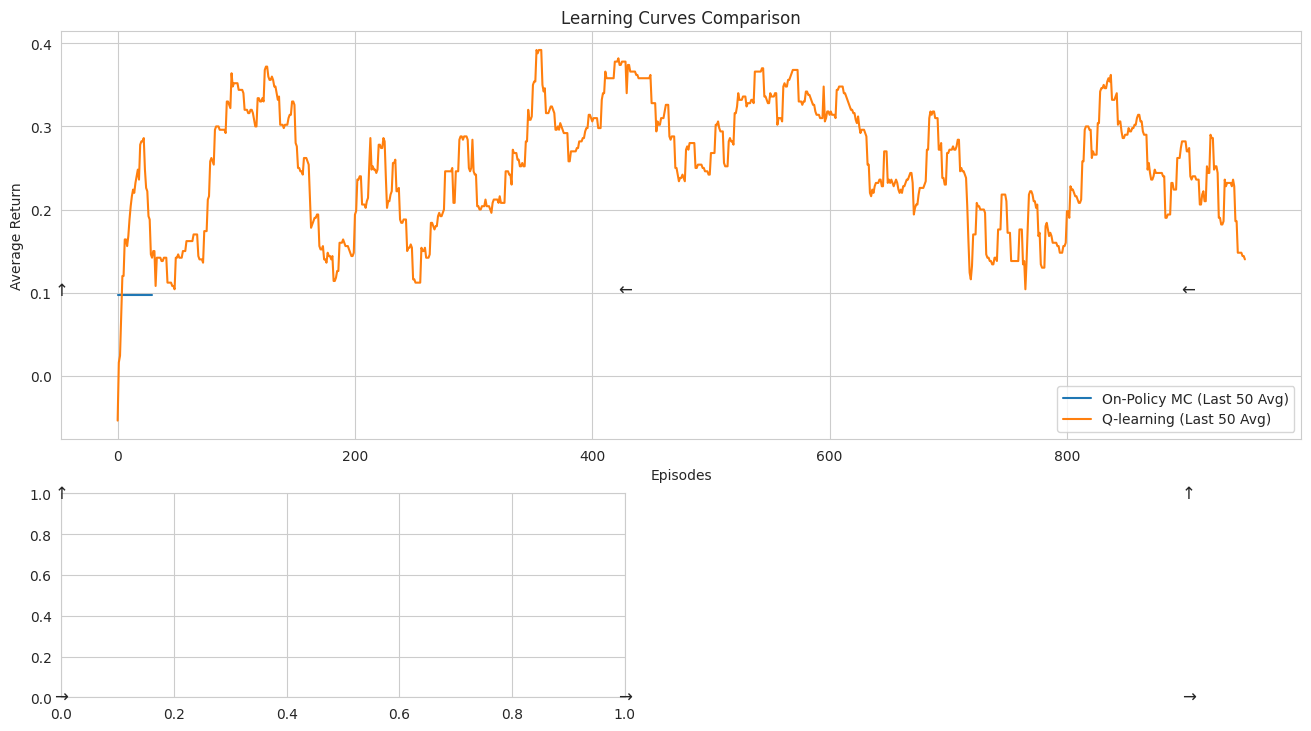

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def visualize_comparison(env, histories, algorithm_names):
    """Comparative visualization of all 4 algorithms"""
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 12))

    # Create custom grid layout
    gs = GridSpec(3, 2, height_ratios=[2, 1, 1])

    # 1. Learning Curves Comparison
    ax1 = plt.subplot(gs[0, :])
    for idx, history in enumerate(histories):
      if len(history['rewards']) > 0:
        rewards = history['rewards']  # Direct access to rewards list
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        ax1.plot(smoothed, label=f"{algorithm_names[idx]} (Last 50 Avg)")
    ax1.set_title("Learning Curves Comparison")
    ax1.set_ylabel("Average Return")
    ax1.set_xlabel("Episodes")
    ax1.legend()

    # 2. Policy Visualization Grid
    ax2 = plt.subplot(gs[1, 0])
    visualize_policy(env, histories[0]['final_policy'], "On-Policy MC Policy", ax2)

    ax3 = plt.subplot(gs[1, 1])
    visualize_policy(env, histories[1]['final_policy'], "Off-Policy MC Policy", ax3)

    ax4 = plt.subplot(gs[2, 0])
    visualize_policy(env, histories[2]['final_policy'], "SARSA Policy", ax4)

    ax5 = plt.subplot(gs[2, 1])
    visualize_policy(env, histories[3]['final_policy'], "Q-learning Policy", ax5)

    plt.tight_layout()
    plt.savefig('algorithm_comparison.png', dpi=300)
    plt.show()

def visualize_policy(env, policy, title, ax=None):
    """Visualize policy on gridworld"""
    if ax is None:
        plt.figure(figsize=(8, 8))

    grid_size = int(np.sqrt(len(policy)))
    grid = np.zeros((grid_size, grid_size))

    # Create arrow mapping
    arrow_map = {
        'up': '↑',
        'down': '↓',
        'left': '←',
        'right': '→'
    }

    for state, action in policy.items():
        row, col = env._state_to_rc(state)
        if env.is_terminal(state):
            grid[row, col] = 2  # Terminal state
        else:
            grid[row, col] = 1 if action is not None else 0
            if action in arrow_map:
                plt.text(col, row, arrow_map[action],
                        ha='center', va='center', fontsize=12)

    # Create heatmap
    cmap = plt.cm.viridis
    cmap.set_under('white')
    ax.imshow(grid, cmap=cmap, vmin=0.1)

    # Add grid lines
    ax.set_xticks(np.arange(-.5, grid_size, 1))
    ax.set_yticks(np.arange(-.5, grid_size, 1))
    ax.grid(which="major", color="gray", linestyle='-', linewidth=2)
    ax.set_title(title)
    ax.axis('off')

def exploration_analysis(histories, algorithm_names):
    """Analyze exploration effectiveness"""
    plt.figure(figsize=(12, 6))

    # Plot exploration rates
    for idx, history in enumerate(histories):
        if 'epsilon' in history:
            epsilons = history['epsilon']
            plt.plot(epsilons, label=algorithm_names[idx])

    plt.title("Exploration Rate Decay Comparison")
    plt.ylabel("Epsilon")
    plt.xlabel("Episodes")
    plt.legend()
    plt.savefig('exploration_decay.png', dpi=300)

    # Plot action diversity
    plt.figure(figsize=(12, 6))
    for idx, history in enumerate(histories):
        diversities = [len(set(episode_actions)) for episode_actions in history['actions']]
        plt.plot(np.convolve(diversities, np.ones(50)/50, mode='valid'),
                label=algorithm_names[idx])

    plt.title("Action Diversity (Unique Actions per Episode)")
    plt.ylabel("Unique Actions")
    plt.xlabel("Episodes")
    plt.legend()
    plt.savefig('action_diversity.png', dpi=300)

def find_convergence_point(rewards, window=50, threshold=0.1):
    """Find when reward stabilizes"""
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    diffs = np.abs(np.diff(smoothed))
    for i, diff in enumerate(diffs):
        if np.all(diff < threshold):
            return i + window
    return len(rewards)

def calculate_optimal_path(env, policy):
    """Calculate path length from start to goal"""
    state = env.start_state
    path = []
    for _ in range(100):  # Prevent infinite loops
        action = policy[state]
        next_states = [t['state'] for t in env.get_transitions(state, action)]
        state = next_states[0]  # Deterministic env
        path.append(action)
        if env.is_terminal(state):
            return len(path)
    return np.inf  # No path found

def generate_report_data(env, histories, algorithm_names):
    """Generate quantitative comparison data"""
    report_data = []

    for idx, history in enumerate(histories):
        algorithm = {
            'name': algorithm_names[idx],
            'convergence_episode': find_convergence_point(history['rewards']),
            'final_reward': np.mean(history['rewards'][-50:]),
            'reward_variance': np.var(history['rewards'][-50:]),
            'optimal_path_length': calculate_optimal_path(env, history['final_policy'])
        }
        report_data.append(algorithm)

    return report_data

gw = GridWorld(height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.0)
Q_values, optimal_policy, mc_on_history, history_mc_on = simple_gw.mc_control(num_episodes=1000, gamma=1.0, epsilon=0.1)
Q_off_policy, policy_off, mc_off_history, history_mc_off = gw.off_policy_mc_control(num_episodes=1000, gamma = 1.0, epsilon = 0.1)
Q_sarsa, policy_sarsa, history_sarsa, history_SARSA = gw.on_policy_td_control(num_episodes=1000, epsilon=0.2, alpha=0.05)
Q_qlearn, policy_qlearn, history_qlearn, history_QLEARN = gw.off_policy_td_control(num_episodes=1000, epsilon=0.2, alpha=0.05)

algorithm_names = ["On-Policy MC", "Off-Policy MC", "SARSA", "Q-learning"]
histories = [history_mc_on, history_mc_off, history_SARSA, history_QLEARN]

# Generate visualizations
visualize_comparison(gw, histories, algorithm_names)
exploration_analysis(histories, algorithm_names)

# Generate report data
report_data = generate_report_data(gw, histories, algorithm_names)

# Print quantitative comparison
print("\nAlgorithm Performance Comparison:")
print(f"{'Algorithm':<15} | {'Convergence':<12} | {'Final Reward':<12} | {'Variance':<8} | {'Path Len'}")
print("-"*65)
for algo in report_data:
  print(f"{algo['name']:<15} | {algo['convergence_episode']:<12} | {algo['final_reward']:<12.2f} | "
  f"{algo['reward_variance']:<8.2f} | {algo['optimal_path_length']}")

In [ ]:
def value_iteration(gw, discount, tolerance=0.1):
    #TO DO:
    iterations = 0

    while True:

        iterations += 1
        max_diff = 0 #max change in value
        new_vals = gw._grid_values.copy()
        #iterate over all states, calculating the new temporary 'max val' for each
        for state in gw.get_states():
            if gw.is_terminal(state):
                continue
            old_val = gw.get_value(state)
            max_val = float('-inf')
            for action in gw.get_actions(state):
                val = 0
                transitions = gw.get_transitions(state, action)
                for transition in transitions:
                    next_state = transition['state']
                    prob = transition['prob']
                    reward = gw.get_reward(next_state)
                    val += prob * (reward + discount * gw.get_value(next_state))
                #if the temp val is a better action to take, update its value
                if val > max_val:
                    max_val = val
            new_vals[state] = max_val
            max_diff = max(max_diff, abs(old_val - max_val))

        gw._grid_values = new_vals

        if max_diff < tolerance:
            break

    return gw._grid_values, iterations


In [ ]:
# Initialize your GridWorld
simple_gw = GridWorld(height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.0)
#noisy_gw = GridWorld(height=5, width=5, goal=14, danger=[2, 18, 21], blocked=[6, 7, 11, 12], noise=0.2)
discount = 0.95
tolerance = 0.1

In [ ]:
value_iteration(simple_gw, discount, 0.1)
print(simple_gw)

  3.15   2.99  -5.00   4.51   4.75 
  3.32   ----   ----   4.75   5.00 
  3.49   ----   ----   5.00   GOAL 
  3.68   3.87   4.07  -5.00   5.00 
  3.49  -5.00   4.29   4.51   4.75 



In [ ]:
#value_iteration(noisy_gw, discount, 0.1)
#print(noisy_gw)

  0.42  -0.10  -5.00   3.60   4.51 
  0.56   ----   ----   4.49   4.88 
  0.65   ----   ----   4.22   GOAL 
  0.72   0.83   1.40  -5.00   4.17 
  0.23  -5.00   2.09   2.90   3.84 



Discount: 0.95, Noise: 0.0, Iterations: 12
Discount: 0.95, Noise: 0.1, Iterations: 15
Discount: 0.95, Noise: 0.2, Iterations: 15
Discount: 0.75, Noise: 0.0, Iterations: 12
Discount: 0.75, Noise: 0.1, Iterations: 8
Discount: 0.75, Noise: 0.2, Iterations: 7


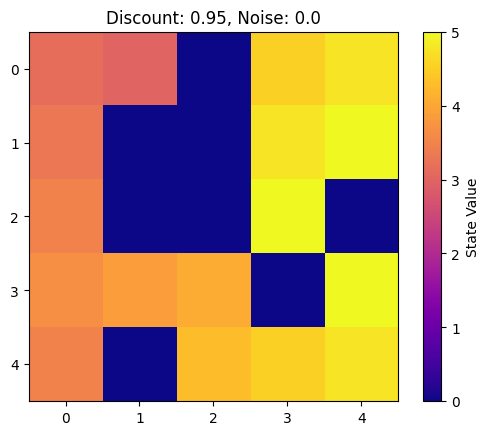

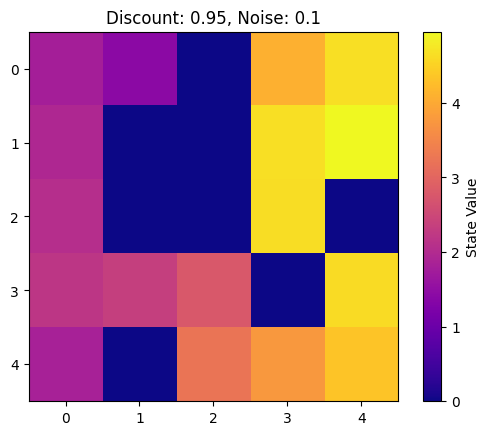

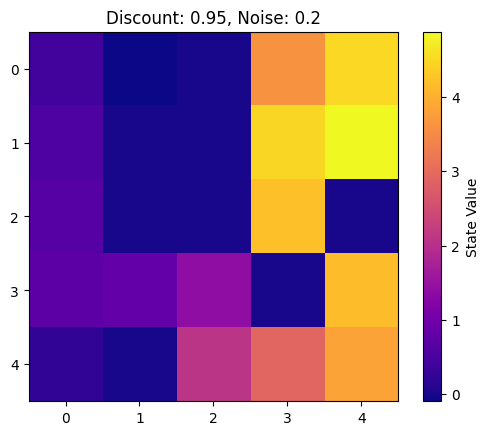

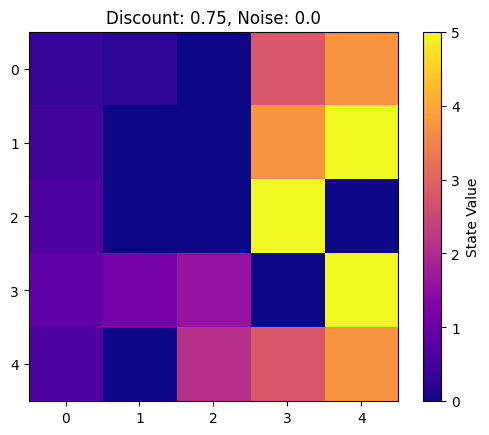

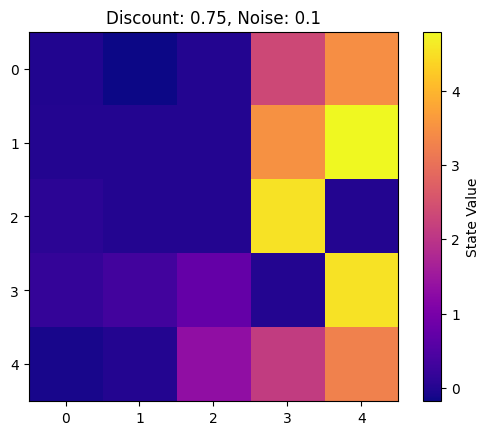

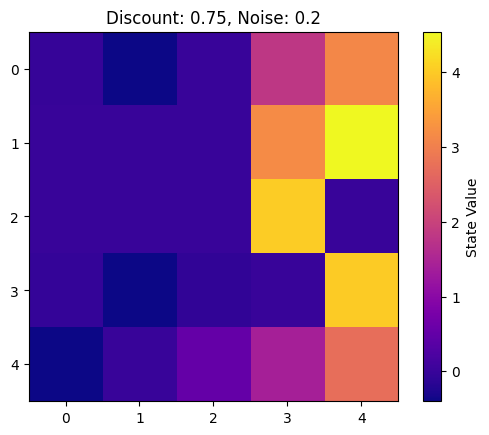

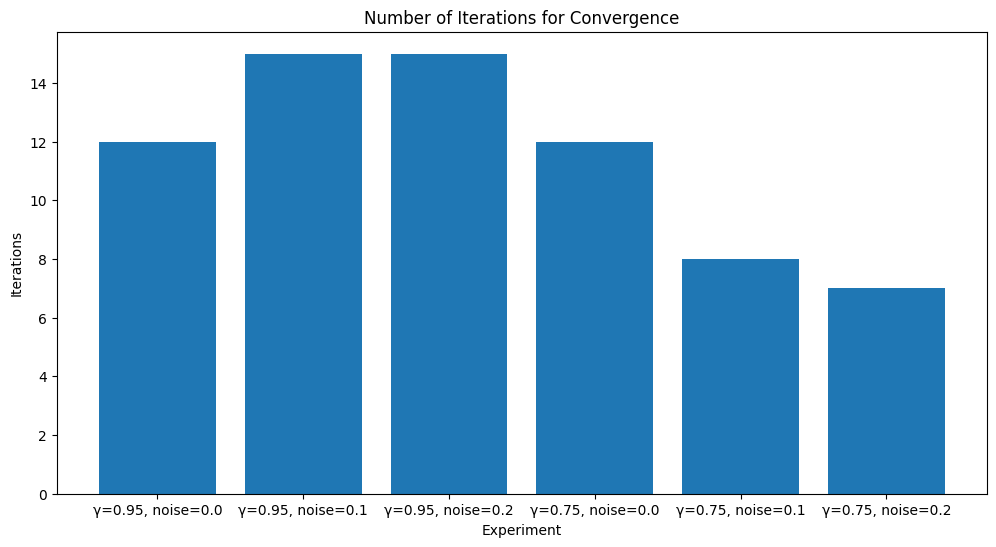

In [ ]:
discount_params = [0.95, 0.75]
noise_params = [0.0, 0.1, 0.2]
results = []

for discount in discount_params:
    for noise in noise_params:
      gw = GridWorld(height=5, width=5, goal=14, danger=[2, 18, 21], blocked=[6, 7, 11, 12], noise=noise)
      values, iterations = value_iteration(gw, discount, 0.1)
      results.append({
            'discount': discount,
            'noise': noise,
            'values': values,
            'iterations': iterations
        })


for result in results:
    print(f"Discount: {result['discount']}, Noise: {result['noise']}, Iterations: {result['iterations']}")

def plot_state_values(values, title):
    grid = np.array(values).reshape((5, 5))
    plt.imshow(grid, cmap='plasma', origin='upper')
    plt.colorbar(label = 'State Value')
    plt.title(title)
    plt.show()
for result in results:
    plot_state_values(result['values'], f"Discount: {result['discount']}, Noise: {result['noise']}")

discounts = [result['discount'] for result in results]
noises = [result['noise'] for result in results]
iterations = [result['iterations'] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(range(len(results)), iterations, tick_label=[f"γ={d}, noise={n}" for d, n in zip(discounts, noises)])
plt.xlabel('Experiment')
plt.ylabel('Iterations')
plt.title('Number of Iterations for Convergence')
plt.show()